<a href="https://colab.research.google.com/github/pabloknappo/spectrogram_learning/blob/main/spectrogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [3]:
#check the tensorflow version and available devices
print("Tensorflow version: " + tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Tensorflow version: 2.6.0
GPU is available


In [4]:
! git clone https://github.com/pabloknappo/spectrogram_learning/

Cloning into 'spectrogram_learning'...
remote: Enumerating objects: 9564, done.
remote: Total 9564 (delta 0), reused 0 (delta 0), pack-reused 9564
Receiving objects: 100% (9564/9564), 1.67 GiB | 18.85 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (9552/9552), done.


In [5]:
! ls

drive  sample_data  spectrogram_learning


In [6]:
#get to the directory with images
path = os.path.join(os.getcwd(),'spectrogram_learning','data')

In [7]:
#change current directory
os.chdir('/content')

In [8]:
print(path)
! ls

/content/spectrogram_learning/data
drive  sample_data  spectrogram_learning


In [9]:
data_dir = path

#image format data
IMG_HEIGHT = 160
IMG_WIDTH = 160
IMG_SIZE = (160, 160)

#set batch size
BATCH_SIZE = 64


In [10]:

#create training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset='training',
  labels='inferred',
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 9549 files belonging to 8 classes.
Using 7640 files for training.


In [11]:
#create validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  labels='inferred',
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 9549 files belonging to 8 classes.
Using 1909 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['3000 rpm no load', '3000 rpm with load', '4000 rpm no load', '4000 rpm with load', '5000 rpm no load', '5000 rpm with load', '6000 rpm no load', '6000 rpm with load']


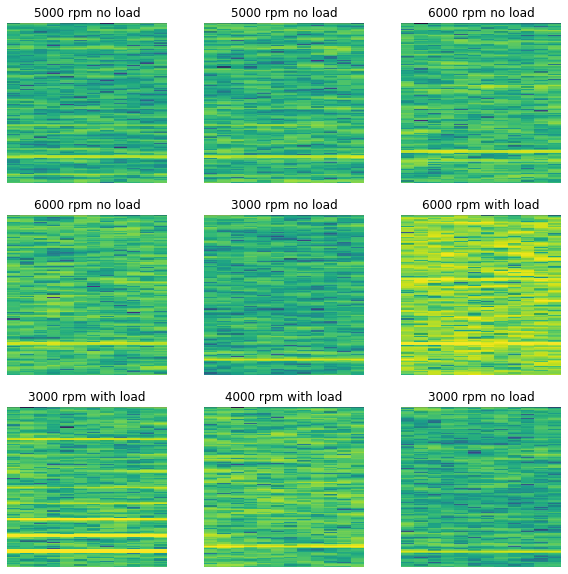

In [ ]:
#visualize the data

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#create a test dataset as a 1/5 part of validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 24
Number of test batches: 6


In [ ]:
#

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
#rescale expected values from [0,255] to [-1,1]

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,) #???????????
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 5, 5, 1280)


In [ ]:
#freeeze conv layers
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
#add classification head

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(8)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 8)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = inputs
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 10248 

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

24/24 [==============================] - 14s 267ms/step - loss: 2.8154 - accuracy: 0.1233


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.82
initial accuracy: 0.12


In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
120/120 [==============================] - 57s 428ms/step - loss: 1.2036 - accuracy: 0.5753 - val_loss: 0.5409 - val_accuracy: 0.9062
Epoch 2/10
120/120 [==============================] - 55s 436ms/step - loss: 0.5216 - accuracy: 0.8449 - val_loss: 0.3652 - val_accuracy: 0.9266
Epoch 3/10
120/120 [==============================] - 53s 417ms/step - loss: 0.3854 - accuracy: 0.8894 - val_loss: 0.2829 - val_accuracy: 0.9325
Epoch 4/10
120/120 [==============================] - 53s 424ms/step - loss: 0.3092 - accuracy: 0.9131 - val_loss: 0.2310 - val_accuracy: 0.9469
Epoch 5/10
120/120 [==============================] - 52s 414ms/step - loss: 0.2740 - accuracy: 0.9212 - val_loss: 0.1943 - val_accuracy: 0.9600
Epoch 6/10
120/120 [==============================] - 53s 424ms/step - loss: 0.2422 - accuracy: 0.9326 - val_loss: 0.1872 - val_accuracy: 0.9593
Epoch 7/10
120/120 [==============================] - 54s 427ms/step - loss: 0.2206 - accuracy: 0.9395 - val_loss: 0.1739 - val_ac

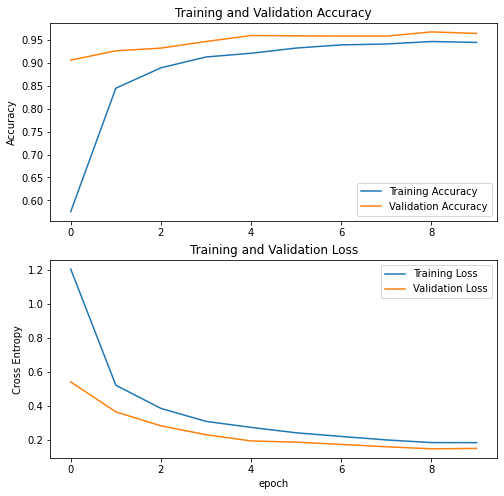

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#fine tuning
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 10248 

In [ ]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
120/120 [==============================] - 62s 439ms/step - loss: 0.2164 - accuracy: 0.9336 - val_loss: 0.0987 - val_accuracy: 0.9672
Epoch 11/20
120/120 [==============================] - 55s 440ms/step - loss: 0.1244 - accuracy: 0.9550 - val_loss: 0.0763 - val_accuracy: 0.9698
Epoch 12/20
120/120 [==============================] - 56s 442ms/step - loss: 0.1004 - accuracy: 0.9648 - val_loss: 0.1328 - val_accuracy: 0.9462
Epoch 13/20
120/120 [==============================] - 55s 436ms/step - loss: 0.0801 - accuracy: 0.9723 - val_loss: 0.3904 - val_accuracy: 0.8839
Epoch 14/20
120/120 [==============================] - 55s 440ms/step - loss: 0.0687 - accuracy: 0.9758 - val_loss: 0.1942 - val_accuracy: 0.9279
Epoch 15/20
120/120 [==============================] - 55s 435ms/step - loss: 0.0589 - accuracy: 0.9779 - val_loss: 0.0625 - val_accuracy: 0.9784
Epoch 16/20
120/120 [==============================] - 54s 431ms/step - loss: 0.0475 - accuracy: 0.9812 - val_loss: 0.1016 -

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

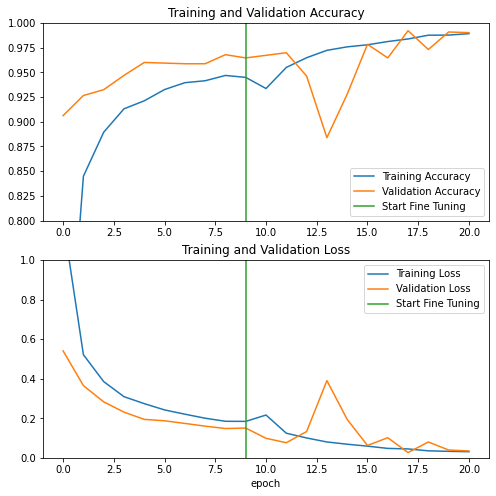

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

6/6 [==============================] - 5s 356ms/step - loss: 0.0291 - accuracy: 0.9844
Test accuracy : 0.984375


In [ ]:
import pandas as pd


image_batch, label_batch = test_ds.as_numpy_iterator().next()
#true_label_ids = np.argmax(label_batch, axis=-1)
print('Image batch shape: ', image_batch.shape)
predictions = model.predict_on_batch(image_batch)
predictions = tf.nn.sigmoid(predictions)
print('Prediction results shape:', predictions.shape)

# Convert prediction results to Pandas dataframe, for better visualization
tf_pred_dataframe = pd.DataFrame(predictions)
tf_pred_dataframe.columns = class_names

Image batch shape:  (64, 160, 160, 3)
Prediction results shape: (64, 8)


In [ ]:
tf_pred_dataframe.head()

,3000 rpm no load,3000 rpm with load,4000 rpm no load,4000 rpm with load,5000 rpm no load,5000 rpm with load,6000 rpm no load,6000 rpm with load
0,"tf.Tensor(0.0031855542, shape=(), dtype=float32)","tf.Tensor(0.0004977361, shape=(), dtype=float32)","tf.Tensor(0.05893178, shape=(), dtype=float32)","tf.Tensor(0.9994791, shape=(), dtype=float32)","tf.Tensor(1.0424711e-05, shape=(), dtype=float32)","tf.Tensor(6.528597e-06, shape=(), dtype=float32)","tf.Tensor(8.932336e-05, shape=(), dtype=float32)","tf.Tensor(6.2752975e-10, shape=(), dtype=float32)"
1,"tf.Tensor(0.0002941576, shape=(), dtype=float32)","tf.Tensor(0.018777894, shape=(), dtype=float32)","tf.Tensor(0.00032664498, shape=(), dtype=float32)","tf.Tensor(0.0046506138, shape=(), dtype=float32)","tf.Tensor(1.3806099e-06, shape=(), dtype=float32)","tf.Tensor(0.6086358, shape=(), dtype=float32)","tf.Tensor(0.035562783, shape=(), dtype=float32)","tf.Tensor(0.9985751, shape=(), dtype=float32)"
2,"tf.Tensor(0.999984, shape=(), dtype=float32)","tf.Tensor(0.00028114996, shape=(), dtype=float32)","tf.Tensor(0.6378095, shape=(), dtype=float32)","tf.Tensor(0.0030418353, shape=(), dtype=float32)","tf.Tensor(1.9571336e-05, shape=(), dtype=float32)","tf.Tensor(9.426687e-09, shape=(), dtype=float32)","tf.Tensor(0.00026351804, shape=(), dtype=float32)","tf.Tensor(1.8401816e-07, shape=(), dtype=float32)"
3,"tf.Tensor(4.8108057e-05, shape=(), dtype=float32)","tf.Tensor(0.0019029812, shape=(), dtype=float32)","tf.Tensor(0.0002885077, shape=(), dtype=float32)","tf.Tensor(0.07126416, shape=(), dtype=float32)","tf.Tensor(0.0031882022, shape=(), dtype=float32)","tf.Tensor(0.9687659, shape=(), dtype=float32)","tf.Tensor(0.2188693, shape=(), dtype=float32)","tf.Tensor(0.34772754, shape=(), dtype=float32)"
4,"tf.Tensor(0.9965256, shape=(), dtype=float32)","tf.Tensor(0.009856435, shape=(), dtype=float32)","tf.Tensor(2.7136039e-06, shape=(), dtype=float32)","tf.Tensor(0.016377933, shape=(), dtype=float32)","tf.Tensor(0.00049351185, shape=(), dtype=float32)","tf.Tensor(5.397602e-07, shape=(), dtype=float32)","tf.Tensor(1.1717571e-05, shape=(), dtype=float32)","tf.Tensor(4.1630293e-11, shape=(), dtype=float32)"


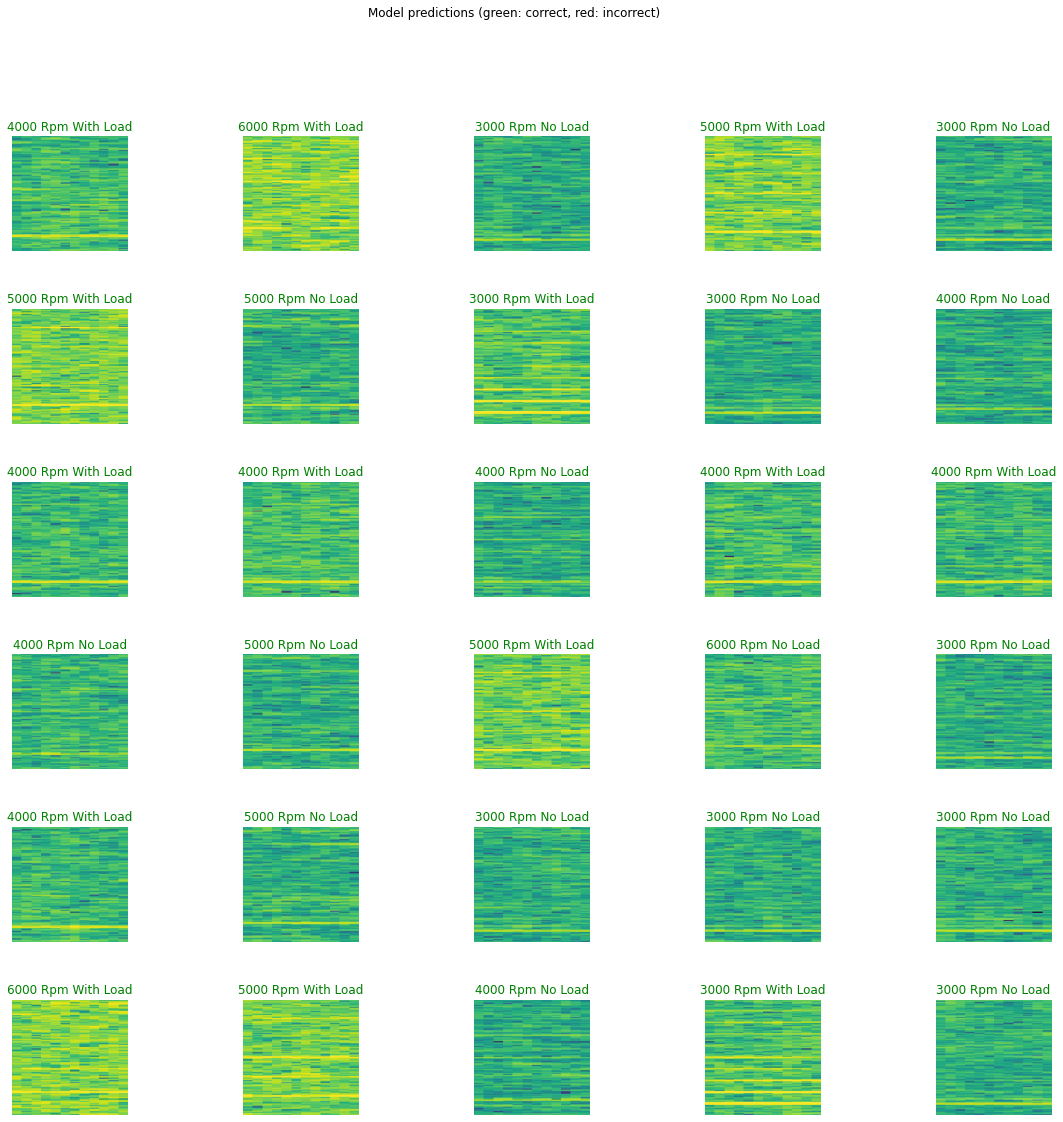

In [ ]:
# Get predictions for each image
predicted_ids = np.argmax(predictions, axis=-1)
predicted_ids = np.array(predicted_ids)
predicted_ids = (list(predicted_ids))
predicted_labels = []
for idx in predicted_ids:
  predicted_labels.append(class_names[idx])


# Print images batch and labels predictions
plt.figure(figsize=(20,18))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n]/255)
  color = "green" if predicted_ids[n] == list(label_batch)[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')
tf.saved_model.save(model,'model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model/assets


In [ ]:
#get to the directory with images
saved_model_dir = os.path.join(os.getcwd(),'model')
print(saved_model_dir)

/content/model


In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [13]:
#create a labels file from class_names list

textfile = open("model_labels.txt", "w")
for element in class_names:
    textfile.write(element + "\n")
textfile.close()
